In [16]:
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython import display
from mpl_toolkits.mplot3d import Axes3D

In [118]:
class TBP():
    ## 一个计算三体问题的第三方库
    class entity: # 定义实体
        def __init__(self,r=1,rou=1,mess=100,coordinate=(0,0),velocity=(0,0)):
            # 实体参数
            self.r=r
            self.m=mess
            self.coor=np.array(coordinate)
            self.vel=np.array(velocity)
            self.rou=rou
        def position(self):
            return self.vel # 报告实体位置
        
    def __init__(self,G=10,num=3,dim=2,dt=0.01,poches=1,min_distance=5,
                 method="直线预测",clash_mode=True,init_report=None,
                 parameter=None,path=None,Smoothness=5):
        ## 参数
        self.G=G # 引力常数
        self.dt=dt # 时间步长
        self.dim=dim # 维度
        self.num=num # 实体个数
        self.method=method # 求解方法
        self.poches=poches # 单次步进次数
        self.clash_mode=clash_mode
        self.Smoothness=Smoothness
        self.history_data=np.zeros((Smoothness,))
        self.name_list=[str(i+1) for i in range(num)] # 现有实体列表，碰撞后合并
        self.min_distance=min_distance # 最小碰撞距离
        ## 初始化
        if type(parameter)==np.ndarray: # 通过读入参数初始化
            self.set_parameter(parameter)
        elif path != None:              # 通过文件参数初始化
            self.load_parameter(path)
        else:                           # 随机初始化
            self.random_parameter(num,dim)
        if init_report == True:
            self.initreport()
            
    def initreport(self,):
        ## 程序初始化报告
        print("加载完成，本次模拟基础信息如下:\n")
        self.head(3)
        
    def initialize_Coor(self):
        ## 返回初始化坐标信息
        Coor_before=np.zeros((self.num,self.dim))
        for i in range(self.num):
            Coor_before[i,:]=self.entities[i].coor
        return Coor_before
        
    def set_parameter(self,parameter):
        ## 手动输入的方法设置参数
        shape=parameter.shape
        num=shape[0]
        dim=int((shape[1]-1)/2)
        self.dim=dim
        self.num=num
        self.entities=[self.entity() for i in range(num)]
        k=0
        for i in self.entities:
            i.r=parameter[k,0]
            i.m=parameter[k,1]
            i.coor=np.array(parameter[k,2:(2+dim)])
            i.vel=np.array(parameter[k,(2+dim):])
            i.rou=i.m/(4/3*np.pi*pow(i.r,3))
            k=k+1
    
    def load_parameter(self,path,dtype=np.float,delimiter=',',unpack=False):
        ## 读取顺序 半径 质量 坐标*dim 速度*dim
        ## 文件读取
        parameter=np.loadtxt(path,dtype=dtype,delimiter=delimiter,unpack=unpack)
        shape=parameter.shape
        num=shape[0]
        dim=int((shape[1]-1)/2)
        self.dim=dim
        self.num=num
        self.entities=[self.entity() for i in range(num)]
        k=0
        for i in self.entities:
            i.r=parameter[k,0]
            i.m=parameter[k,1]
            i.coor=np.array(parameter[k,2:(2+dim)])
            i.vel=np.array(parameter[k,(2+dim):])
            i.rou=i.m/(4/3*np.pi*pow(i.r,3))
            k=k+1
            
    def random_parameter(self,num,dim):
        ## 随机化初始参数
        self.entities=[self.entity() for i in range(num)]
        for i in self.entities:
            i.r=np.random.randint(25,36,(1,))
            i.m=np.random.randint(1e8,2e8+1,(1,))
            i.coor=np.random.randint(-14e3,14e3+1,(dim,))
            i.vel=np.random.randint(-4e3,4e3+1,(dim,))
            i.rou=i.m/(4/3*np.pi*pow(i.r,3))

    def head(self,n=10,state_only=False):
        ## 模拟模型概要
        if state_only != True:
            print("模拟信息:")
            print("  实体数量:%-8s\t时间步长:%-8s\tpoches:%-8s\t求解方法:%-8s"%(self.num,self.dt,self.poches,self.method))
            print("  空间维度:%-8s\t引力常数:%-8s\t碰撞判断:%-8s"%(self.dim,self.G,str(self.clash_mode)),end='\n\n')
        if n<0 or n>self.num:
            n=self.num
        print("实体信息:")
        for i in range(n):
            print("%d号实体参数如下:\n"%(i+1),
                  " 半径:%-12.4e\t质量:%-12.4e\t密度:%-12.4e"%(self.entities[i].r,self.entities[i].m,self.entities[i].rou),
                  "\n  坐标:"+'['+','.join([format(k,'.4e') for k in list(self.entities[i].coor)])+']',
                  "\t速度:"+'['+','.join([format(k,'.4e') for k in list(self.entities[i].vel)])+']')
            
    def run(self,step=1,times=1,Coor_before=None,process_display=True,
            image_display=False,image_mode=2,image_i=1):
        ## 运行模拟
        dt=self.dt
        method=self.method
        timer=0
        #print("test  ",dt," ",method)
        start_time=time.time()
        if self.dim<image_mode:
            raise Exception('\033[1;33mDim Error:\033[3;31m<dim:%s is not bigger than mode:'%self.dim+str(image_mode)+'>')
        if image_display == True:
            process_display=False
        if type(Coor_before)==type(None):
            Coor_before=self.initialize_Coor()
        for p in range(times):
            flag=0
            sight_data=0
            if type(method)==str:
                if method == "simple":
                    flag=self.simple_step(Coor_before)
                elif method=="直线预测":
                    flag=self.line_step(Coor_before)
                elif method=="中心差商":
                    flag,Coor_before=self.centre_step(Coor_before)
                elif method=="二次递推":
                    flag=self.dou_step(Coor_before)
                elif method=="runge_kutaa":
                    flag=self.runge_kutaa_step()
                else:
                    raise Exception('\033[1;33mMethod Not Found:\033[3;31m<method \'%s\'>'%self.method)
            else:
                raise Exception('\033[1;33mError Type:\033[3;31m<method \'%s\'>'%str(self.method)+
                                '\033[1;33m type:\033[3;31m%s'%type(self.method))
            if flag==-1:
                print("仅剩唯一实体，模拟结束\n")
                self.head()
                break
            if process_display == True:
                self.step_info(p=p,times=times,start_time=start_time)
            if image_display == True:
                sight_data=self.screen(mode=image_mode,i=image_i[0],j=image_i[1],k=image_i[2])
                self.history_data[timer]=sight_data
                timer=timer+1
                if timer>=self.Smoothness:
                    timer=0
                    
        return Coor_before
        
    def force(self,i,Coor_pre=None):
        ## 实体受力分解
        F=np.zeros((self.dim,))
        if type(Coor_pre) == type(None):
            for j in range(self.num):
                if i != j :
                    dis2=np.sum(np.square(self.entities[i].coor-self.entities[j].coor))
                    fG=self.G * self.entities[i].m * self.entities[j].m/dis2
                    F=F+(fG/np.sqrt(dis2))*(self.entities[j].coor-self.entities[i].coor)
            return F
        else:
            for j in range(self.num):
                if i != j :
                    dis2=np.sum(np.square(Coor_pre[i,:]-Coor_pre[j,:]))
                    fG=self.G * self.entities[i].m * self.entities[j].m/dis2
                    F=F+(fG/np.sqrt(dis2))*(Coor_pre[j,:]-Coor_pre[i,:])
            return F
        
    def line_step(self,Coor_before=None):
        ## 欧拉折线 & 预测修正 方法
        for p in range(self.poches):
            a_before=np.zeros((self.num,self.dim))
            Coor_pre=np.zeros((self.num,self.dim))
            for i in range(self.num):
                f=self.force(i)
                a=f/self.entities[i].m
                a_before[i,:]=a
                Coor_pre[i,:]=1/2*self.dt*self.dt*a+self.entities[i].coor# 预测坐标
            for i in range(self.num):
                fx_pre=self.force(i=i,Coor_pre=Coor_pre)
                a_pre=fx_pre/self.entities[i].m
                v_before=self.entities[i].vel
                self.entities[i].vel=1/2*(a_before[i,:]+a_pre)*self.dt+self.entities[i].vel
                self.entities[i].coor=1/2*(v_before+self.entities[i].vel)*self.dt+self.entities[i].coor
            if self.clash_mode==True:
                self.is_clash()
            if self.num<=1:
                return -1
                break
        return 0
    
    def centre_step(self,Coor_before=None):
        ## 中心差商 方法
        for p in range(self.poches):
            a_before=np.zeros((self.num,self.dim))
            Coor_pre=np.zeros((self.num,self.dim))
            for i in range(self.num):
                f=self.force(i)
                a=f/self.entities[i].m
                a_before[i,:]=a
                Coor_pre[i,:]=self.dt*self.dt*a+2*self.entities[i].coor-Coor_before[i,:] # 预测坐标
            for i in range(self.num):
                fx_pre=self.force(i=i,Coor_pre=Coor_pre)
                a_pre=fx_pre/self.entities[i].m
                v_before=self.entities[i].vel
                self.entities[i].vel=1/2*(a_before[i,:]+a_pre)*self.dt+self.entities[i].vel
                Coor_before[i,:]=self.entities[i].coor
                self.entities[i].coor=1/2*(v_before+self.entities[i].vel)*self.dt+self.entities[i].coor
            if self.clash_mode==True:
                self.is_clash()
            if self.num<=1:
                return (-1,Coor_before)
                break
        return (0,Coor_before)
    
    def dou_step(self,Coor_before=None):
        raise Exception('\033[1;33mMethod Not Defined:\033[3;31m<method \'%s\'>'%self.method)
        if self.clash_mode==True:
            self.is_clash()
        return 0
        
    def simple_step(self,Coor_before=None):
        ## 欧拉折线方法
        for p in range(self.poches):
            a=np.zeros((self.num,self.dim))
            f=np.zeros((self.num,self.dim))
            for i in range(self.num):
                f[i,:]=self.force(i)
                a[i,:]=f[i,:]/self.entities[i].m
            for i in range(self.num):
                self.entities[i].coor=self.entities[i].vel*self.dt+1/2*a[i,:]*self.dt*self.dt+self.entities[i].coor
                self.entities[i].vel=a[i,:]*self.dt+self.entities[i].vel
            if self.clash_mode==True:
                self.is_clash()
            if self.num<=1:
                return -1
                break
        return 0
            
    def runge_kutaa_step(self,s=4,b=np.array([1/6,2/6,2/6,1/6]),
                         c=np.array([0,1/2,1/2,1]),a=[[],[1/2],[0,1/2],
                                                      [0,0,1]]):
        h=self.dt
        for u in range(self.poches):
            Coor_before=self.initialize_Coor()
            Coor_pre=np.zeros((self.num,self.dim))
            vel_pre=np.zeros((self.num,self.dim))
            for i in range(self.num):
                Coor_pre[i,:]=self.entities[i].coor
                vel_pre[i,:]=self.entities[i].vel
                K=np.zeros((s,self.dim))
                L=np.zeros((s,self.dim))
                for j in range(s):
                    K[j,:]=self.entities[i].vel
                    Coor_now=Coor_before[i,:]
                    f=self.force(i)
                    L[j,:]=f/self.entities[i].m
                    for p in range(j):
                        K[j,:]=K[j,:]+h*a[j][p]*L[p,:]
                        Coor_now=Coor_now+h*a[j][p]*K[p,:]
                    Coor=Coor_before
                    Coor[i,:]=Coor_now
                    f=self.force(i,Coor)
                    L[j,:]=f/self.entities[i].m
                for j in range(s):
                    Coor_pre[i,:]=Coor_pre[i,:]+h*b[j]*K[j,:]
                    vel_pre[i,:]=vel_pre[i,:]+h*b[j]*L[j,:]
            for i in range(self.num):
                self.entities[i].coor=Coor_pre[i,:]
                self.entities[i].vel=vel_pre[i,:]
            if self.clash_mode==True:
                self.is_clash()
            if self.num<=1:
                return -1
                break
        return 0

    def step_info(self,p,times,start_str='',end_str='',total_length=40,start_time=0):
        ## 步进信息 进度条
        percent=(p+1)/times
        n=int(percent * total_length)
        bar ='='*(n+1)
        bar = ('\r' + start_str + '  [' + bar.ljust(total_length) +
               "]  Percent:"+'<{:0>4.1f}%'.format(percent*100)+ '/100.0%>'+
               "  Process:<"+str(p+1)+'/'+str(times)+'>'+
               "  Time:<"+format(time.time()-start_time,'.2')+'s>')
        if p == 0:
            print("  Process:  <%s Poches>"%str(self.poches))
        print(bar, end='', flush=True)
        if percent>=1:
            print('\n  complete.')
            print('_'*(total_length+62),end='\n')

    def index_10(self,number):
        ## 展示器用缩放比例核算函数
        n=number
        count=0
        if n<0:
            return 0
        while(n>=1):
            n=n/10
            count=count+1
        return count
    
    def clash(self,i,j):
        # 碰撞后参数核算（统一为实体合并）
        max_ij=max(i,j)
        min_ij=min(i,j)
        self.name_list[min_ij]=self.name_list[min_ij]+","+self.name_list[max_ij]
        self.name_list.pop(max_ij)
        self.num=self.num-1
        m_new=self.entities[i].m+self.entities[j].m
        self.entities[min_ij].coor=(self.entities[i].m/m_new)*self.entities[i].coor+(self.entities[j].m/m_new)*self.entities[j].coor
        self.entities[min_ij].vel=(self.entities[i].m/m_new)*self.entities[i].vel+(self.entities[j].m/m_new)*self.entities[j].vel
        self.entities[min_ij].m=self.entities[min_ij].m+self.entities[max_ij].m
        self.entities[min_ij].r=pow(pow(self.entities[i].r,3)+pow(self.entities[j].r,3),1/3)
        self.entities[min_ij].rou=self.entities[min_ij].m/(4/3*np.pi*pow(self.entities[min_ij].r,3))
        self.entities.pop(max_ij)
        self.clash_report(i,j)
        
    def clash_report(self,i,j):
        pause_time=5
        print("碰撞信息:\n  实体<%d,%d>碰撞，系统暂停<%.2f>s\n"%(i+1,j+1,pause_time))
        print("%-8s\t%s"%("编号","包含实体"))
        n=1
        for i in self.name_list:
            print("  %-6s\t  %s"%(str(n),i))
            n=n+1
        print('')
        time.sleep(pause_time)

    def is_clash(self):
        # 判断是否碰撞
        i=0
        while(1):
            for j in range(i+1,self.num):
                distance_coor=np.sqrt(np.sum(np.square(self.entities[i].coor-self.entities[j].coor)))
                distance_clash=self.min_distance*(self.entities[i].r+self.entities[j].r)
                if distance_coor <= distance_clash:
                    self.clash(i,j)
                    i=0
                    break
            i=i+1
            if i > self.num:
                break
        return 0
    
    def screen(self,mode=1,i=1,j=2,k=3):
        ## 动态展示器
        sight_data=0
        coor=self.initialize_Coor()
        centre=self.mess_centre()
        max_sight=np.max(np.abs(coor-centre),axis=0)
        num=int((self.dim-np.mod(self.dim,mode))/mode)
        display.clear_output(wait=True)
        if mode == 3:
            sight_data=self.display_3D(coor=coor,centre=centre,max_sight=max_sight,i=i-1,j=j-1,k=k-1)
        if mode == 2:
            sight_data=self.display_2D(coor=coor,centre=centre,max_sight=max_sight,i=i-1,j=j-1,)
        if mode == 1:
            sight_data=self.display_line(coor=coor,centre=centre,max_sight=max_sight,i=i-1)
        plt.pause(0.00001)
        return sight_data
        
    def display_3D(self,coor,centre,max_sight,i,j,k):
        ## 使用3维展示
        coor=coor[:,[i,j,k]]
        centre=centre[[i,j,k]]
        now_max_sight=np.max(max_sight[[i,j,k]])
        history_max_sight=np.max(self.history_data)
        max_sight=np.max((now_max_sight,history_max_sight))
        map_num=pow(10,self.index_10(np.max(coor))-2)*2
        coor=coor/map_num
        centre=centre/map_num
        max_sight=1.2*max_sight/map_num
        ax=Axes3D(plt.figure())
        ax.scatter(coor[:,0],coor[:,1],coor[:,2],c='r')
        ax.set_xlim([centre[0]-max_sight,centre[0]+max_sight])
        ax.set_ylim([centre[1]-max_sight,centre[1]+max_sight])
        ax.set_zlim([centre[2]-max_sight,centre[2]+max_sight])
        ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
        ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
        ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
        ax.set_title("dim:<%s-%s-%s>  scale:<%s>"%(str(i+1),str(i+2),str(i+3),str(map_num)),fontdict={'size': 15, 'color': 'red'})
        return now_max_sight
    
    def display_2D(self,coor,centre,max_sight,i,j):
        ## 使用二维展示
        coor=coor[:,[i,j]]
        centre=centre[[i,j]]
        now_max_sight=np.max(max_sight[[i,j]])
        history_max_sight=np.max(self.history_data)
        max_sight=np.max((now_max_sight,history_max_sight))
        map_num=pow(10,self.index_10(np.max(coor))-2)*2
        coor=coor/map_num
        centre=centre/map_num
        max_sight=1.2*max_sight/map_num
        plt.plot(coor[:,0],coor[:,1],'ro')
        plt.axis([centre[0]-max_sight,centre[0]+max_sight,
                  centre[1]-max_sight,centre[1]+max_sight])
        plt.xlabel("X",fontsize=15,color='red')
        plt.ylabel("Y",fontsize=15,color='red')
        plt.title("dim:<%s-%s>  scale:<%s>"%(str(i+1),str(i+2),str(map_num)),fontdict={'size': 15, 'color': 'red'})
        return now_max_sight
        
    def display_line(self,coor,centre,max_sight,i):
        ## 一维展示
        coor=coor[:,i]
        centre=centre[i]
        now_max_sight=np.max(max_sight[i])
        history_max_sight=np.max(self.history_data)
        max_sight=np.max((now_max_sight,history_max_sight))
        map_num=pow(10,self.index_10(np.max(coor))-2)*2
        coor=coor/map_num
        centre=centre/map_num
        max_sight=1.2*max_sight/map_num
        plt.plot(coor,np.ones((self.dim,)),'ro')
        plt.axis([centre-max_sight,centre+max_sight,0,2])
        plt.xlabel("X",fontsize=15,color='red')
        plt.title("dim:<%s>  scale:<%s>"%(str(i+1),str(map_num)),fontdict={'size': 15, 'color': 'red'})
        return now_max_sight
    
    def mess_centre(self):
        m_c=np.zeros((self.dim,))
        M=0
        for i in range(self.num):
            M=M+self.entities[i].m
        for i in range(self.num):
            m_c=m_c+self.entities[i].m/M*self.entities[i].coor
        return m_c

In [119]:
a=TBP(G=600,dt=0.001,poches=50,method="simple",
      clash_mode=True,min_distance=2,
      init_report=True,path=r'parameter.csv',Smoothness=20)
## G：引力常量；  dt：步长；  poches：单次步进计算次数；  method：求解方法（直线预测，中心差商，simple，二次递推）；
## init_report：初始化完成报告；  path：使用文件读入的方式初始化，给出文件路径
## clash_mode：是否开启碰撞判断   Smoothness：显示器光滑程度（记录历史数据的个数）

加载完成，本次模拟基础信息如下:

模拟信息:
  实体数量:3       	时间步长:0.001   	poches:50      	求解方法:simple  
  空间维度:3       	引力常数:600     	碰撞判断:True    

实体信息:
1号实体参数如下:
  半径:3.1400e+01  	质量:1.9452e+08  	密度:1.5000e+03   
  坐标:[-5.8213e+03,4.1856e+03,-5.2754e+03] 	速度:[-3.0448e+03,8.5843e+02,-3.9890e+02]
2号实体参数如下:
  半径:2.8528e+01  	质量:1.4587e+08  	密度:1.5000e+03   
  坐标:[3.2389e+03,5.4057e+03,-2.9956e+03] 	速度:[1.2961e+03,-6.7073e+02,2.7354e+03]
3号实体参数如下:
  半径:3.0784e+01  	质量:1.8329e+08  	密度:1.5000e+03   
  坐标:[-4.8712e+03,2.2692e+03,1.6450e+03] 	速度:[3.2591e+02,2.9595e+03,-1.8818e+03]


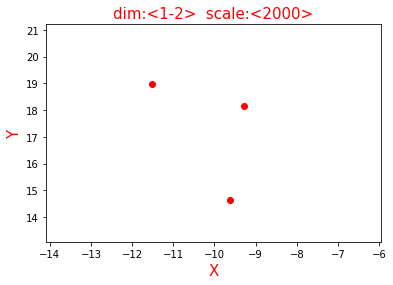

In [121]:
Coor_before=a.run(times=100,process_display=True,image_display=True,image_mode=2,image_i=[1,2,3])
## times：本次运行次数（总求解次数=times*poches）;  process_display：以进度条的方式展示求解过程；
## image_display：以动态图像的方式展示求解过程（优先使用动态图形展示）(注意，动态图的方式大幅延长求解时间)
## image_mode：展示器维度个数（1、2、3）；  image_i：指定展示的维度（孙顺序）